In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from collections import Counter
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

Using TensorFlow backend.


In [2]:
sms_spam_2 = pd.read_csv('C:/Users/anupa/Desktop/SMS_SPAM_Vidya/sms_spam_2.csv', encoding = 'latin-1')
sms_spam_2.head()

,v1,v2
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."


In [3]:
sms_spam_2.rename(columns = {'v1': 'type', 'v2': 'text'}, inplace = True)
sms_spam_2.head()

,type,text
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."


In [4]:
sms_spam_1 = pd.read_csv('C:/Users/anupa/Desktop/SMS_SPAM_Vidya/sms_spam_1.csv', encoding = 'latin-1')
sms_spam_1.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [5]:
final_spam = pd.concat([sms_spam_1, sms_spam_2], axis=0) 
#vertical concatenation axis = 0 means data is stacked one below the other

In [6]:
final_spam.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [7]:
final_spam.to_csv (r'C:/Users/anupa/Desktop/SMS_SPAM_Vidya/final_dataset.csv', index = False, header=True)

In [8]:
final_spam['type'].value_counts()

ham     8680
spam    1336
Name: type, dtype: int64

In [9]:
final_spam['label'] = final_spam['type'].map({'ham': 0, 'spam': 1})
final_spam.head()

,type,text,label
0,ham,Hope you are having a good week. Just checking in,0
1,ham,K..give back my thanks.,0
2,ham,Am also doing in cbe only. But have to pay.,0
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000...",1
4,spam,okmail: Dear Dave this is your final notice to...,1


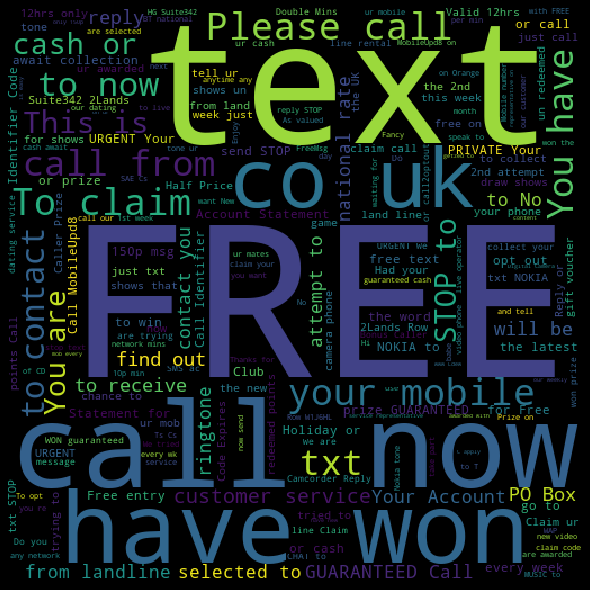

In [10]:
spam_words = ' '.join(list(final_spam[final_spam['label'] == 1]['text']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

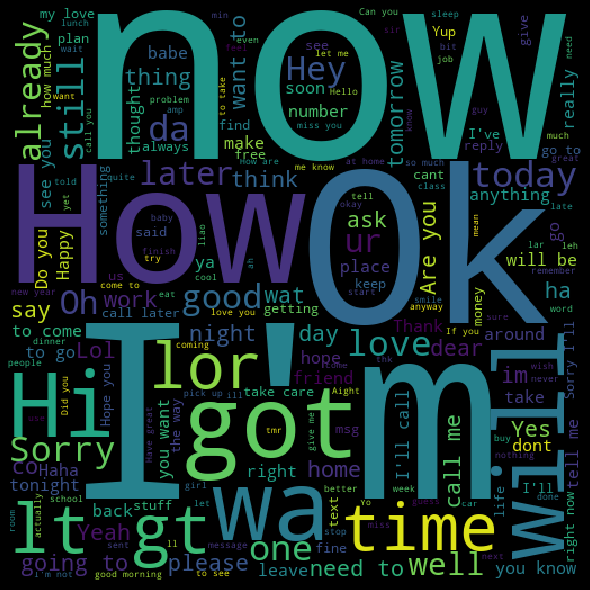

In [11]:
ham_words = ' '.join(list(final_spam[final_spam['label'] == 0]['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [12]:
final_spam_train = final_spam.sample(frac=.8, random_state=11)
final_spam_test = final_spam.drop(final_spam_train.index)
print(final_spam_train.shape,final_spam_test.shape)

(8013, 3) (587, 3)


In [13]:
y_train = final_spam_train['label'].values
y_test = final_spam_test['label'].values


In [14]:
X_train = final_spam_train['text'].values
X_test = final_spam_test['text'].values

In [15]:
#word_dict is a list, ordered by the most frequent words (they come first in the list)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_dict = tokenizer.index_word
#print(len(word_dict))
#print(word_dict)

#for key in word_dict.keys():
#    print(key, word_dict[key])

In [16]:
#text_to_sequences puts the index-numbers from word_dict in the place of the words in the training- and test-data
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq[:5])
print(final_spam_train.iloc[0,:])
for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

[[133, 2, 30, 442], [38, 141, 38, 1948, 50, 1763], [108, 2544, 230, 19, 1168, 322, 8, 37, 799, 41, 35, 1169, 43, 19, 341, 695, 2241, 26, 27, 2545, 182, 72, 74, 261, 2, 2546, 3938, 3939, 80, 19, 3940], [46, 301, 284, 59, 35, 203, 563, 3941, 1352, 26, 3942, 1352, 1465, 5, 3943, 2547, 2242, 584, 47, 37, 3944, 90, 3, 1258], [155, 151, 9, 269, 696, 186, 114, 51, 5, 270, 271, 71, 198, 3945, 25, 463, 7, 322, 22, 378]]
type                     ham
text     Where to get those?
label                      0
Name: 1670, dtype: object
where to get those 

In [17]:
X_train_pad = pad_sequences(X_train_seq, maxlen=20, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=20, padding='post')
X_train_pad[:5]
X_train_pad.shape

(8013, 20)

In [18]:
max_vocab = 10000
max_len = 20
embedding_mat_columns = 32
model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim = embedding_mat_columns,
                    input_length = max_len))
model.add(LSTM(units=embedding_mat_columns))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
             metrics=['acc'])
model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, 
                        validation_data=(X_test_pad, y_test))




Train on 8013 samples, validate on 587 samples
Epoch 1/10





8013/8013 [==============================] - 3s 408us/step - loss: 0.1546 - acc: 0.9495 - val_loss: 0.0623 - val_acc: 0.9847
Epoch 2/10
8013/8013 [==============================] - 2s 207us/step - loss: 0.0325 - acc: 0.9915 - val_loss: 0.0444 - val_acc: 0.9881
Epoch 3/10
8013/8013 [==============================] - 2s 214us/step - loss: 0.0170 - acc: 0.9958 - val_loss: 0.0427 - val_acc: 0.9898
Epoch 4/10
8013/8013 [==============================] - 2s 212us/step - loss: 0.0102 - acc: 0.9974 - val_loss: 0.0312 - val_acc: 0.9915
Epoch 5/10
8013/8013 [==============================] - 2s 209us/step - loss: 0.0060 - acc: 0.9985 - val_loss: 0.0311 - val_acc: 0.9949
Epoch 6/10
8013/8013 [==============================] - 2s 217us/step - loss: 0.0047 - acc: 0.9989 - val_loss: 0.0404 - val_acc: 0.9949
Epoch 7/10
8013/8013 [==============================] - 2s 217us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0338 - val_acc: 

In [20]:
accuracy = model.evaluate(X_test_pad,y_test)
print("Accuracy is {0:2f}".format(accuracy[1]))

587/587 [==============================] - 0s 68us/step
Accuracy is 0.994889


In [21]:
sms_test = ['Please arrange a meeting @ 4.00pm']
sms_seq = tokenizer.texts_to_sequences(sms_test)

sms_pad = pad_sequences(sms_seq, maxlen=20, padding='post')
tokenizer.index_word
sms_pad
prediction = model.predict_classes(sms_pad)
if prediction:
    print ("Spam sms")
else:
    print ("Genuine sms")

Genuine sms


In [22]:
sms_test = ['Free!Register immediately to claim your reward']
sms_seq = tokenizer.texts_to_sequences(sms_test)

sms_pad = pad_sequences(sms_seq, maxlen=20, padding='post')
tokenizer.index_word
sms_pad
prediction = model.predict_classes(sms_pad)
if prediction:
    print ("Spam sms")
else:
    print ("Genuine sms")

Spam sms
